In [2]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

# scipy is an extension for numpy, used extensively in scientific computing
from scipy.sparse import linalg
from scipy.sparse import lil_matrix, csc_matrix
from scipy import stats     

import pygmsh

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../FEM')

import Mesher
import Matrix
import PoroElasticProperties as prop

1115


(-0.3, 10.0)

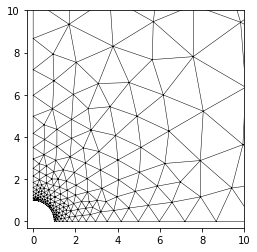

In [3]:
# we define the mesh
r = 1
boxL = 50 * r
cell_size = 0.02

# problem geometry
radius = 1
ntheta = 10
theta = np.linspace(0, np.pi/2, ntheta)
box_length = 50*radius

vertices = np.vstack((np.cos(theta), np.sin(theta))).T
other_vertices = np.array([[0, box_length],
                            [box_length, box_length],
                            [box_length, 0]])
vertices = np.vstack((vertices, other_vertices))

resolutions = 10 * np.ones(len(vertices))
resolutions[:ntheta] = 0.1

with pygmsh.geo.Geometry() as geom:
    # we initiate an empty line list
    lines = []

    # we instantiate points p1 and p2 and make sure to store the first one in p0
    p1 = p0 = geom.add_point(vertices[0], resolutions[0])

    # at every iteration, we make a line going from p1 to p2
    for i in range(len(vertices) - 1):
        p2 = geom.add_point(vertices[i + 1], resolutions[i + 1])
        line = geom.add_line(p1, p2)
        lines.append(line)
        p1 = p2  # we make sure that p1 becomes p2, the next point to be in lines

    # we add the last line, closing the loop with p2 to p0
    lines.append(geom.add_line(p2, p0))

    # curve loop is a collection of lines where every endpoints are connected
    loop = geom.add_curve_loop(lines)  

    # the plane surface is the area that is going to be partitionned in finite elements
    surf = geom.add_plane_surface(loop)
    

    out = geom.generate_mesh()

mesh = Mesher.Mesh(out, simultype='2D')
mesh = Mesher.tri3_2_tri6(mesh)
mesh.plot()
print(mesh.nn)
plt.xlim(-0.3, 10)
plt.ylim(-0.3, 10)

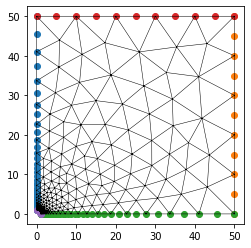

In [4]:
# we get the boundaries needed to enforce boundary conditions
left = np.argwhere(np.abs(mesh.nodes[:, 0] - mesh.nodes[:, 0].min()) <= 1e-4)[:, 0]
right = np.argwhere(np.abs(mesh.nodes[:, 0] - mesh.nodes[:, 0].max()) <= 1e-4)[:, 0]
bottom = np.argwhere(np.abs(mesh.nodes[:, 1] - mesh.nodes[:, 1].min()) <= 1e-4)[:, 0]
top = np.argwhere(np.abs(mesh.nodes[:, 1] - mesh.nodes[:, 1].max()) <= 1e-4)[:, 0]
tunnel = np.argwhere(np.abs(np.linalg.norm(mesh.nodes, axis=1) - radius) <= 1e-4)[:, 0]

mesh.plot()
# where do we enforce boundaries
for boundary in [left, right, bottom, top, tunnel]:
    plt.scatter(*mesh.nodes[boundary].T)


(2, 1115)
1115
520


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x1f737720c10>)

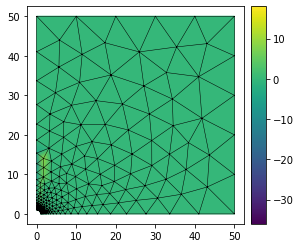

In [5]:
# we get the corresponding degree of freedom for the boundaries with no displacement
dof_left = 2*left
dof_bottom = 2*bottom + 1
nodes_fixed = np.unique(np.hstack((left, bottom)))
dof_fixed = np.unique(np.hstack((dof_left, dof_bottom)))

# we set the initial stress field
p0 = 30  # mean compressive
s0 = 10  # mean deviatoric
stress_field = -np.array([p0-s0, p0+s0, 0])
sigma = Matrix.set_stress_field(mesh, stress_field)

fx_right = np.sum(sigma[right * 2])/box_length
fy_top = np.sum(sigma[top * 2 + 1])/box_length

# we set the initial pore pressure field, it is zero on the tunnel's boundary
h0 = 3  # [Mpa]
pore_pressure_free = np.setdiff1d(np.arange(mesh.nn), tunnel)
h = np.zeros(mesh.nn)
h[pore_pressure_free] = h0

print(sigma.reshape(2, -1, order='F').shape)
print(mesh.nn)
print(mesh.ne)

mesh.plot(sigma.reshape(2, -1, order='F')[0])

In [6]:
# geomechanical parameters
k = 8.4e3  # elastic drained bulk modulus [MPa]
g = 6.8e3  # shear modulus [MPa]
b = 0.707692  # biot coefficient
M = 9.18478e3  # biot modulus [MPa]
k_u = prop.undrained_bulk_modulus(k, b, M)
perm = 0.137549e-3  # permeability
B = (k_u-k)/(b*k_u)
mu_f = 1  # fluid viscosity
rho = 1  # density
kappa = perm/mu_f  # conductivity
nu_u = prop.poisson_ratio(g, k_u)  # undrained poisson ratio
E_u = prop.young_modulus(g, k_u)  # undrained yougn modulus
nu = prop.poisson_ratio(g, k)  # poisson ratio
E = prop.young_modulus(g, k)  # young modulus
eta = b*(1-2*nu_u)/(2*(1-nu_u))  # idk what this is

In [7]:
# we build the necessary matrices
K = Matrix.assemble_stiffness_matrix(mesh, E, nu)
S = Matrix.assemble_mass_matrix(mesh, 1/M)
C = Matrix.assemble_conductivity_matrix(mesh, kappa)
Ce = Matrix.assemble_coupling_matrix(mesh, b)

# we assemble the force vector
fx = Matrix.assemble_tractions_over_line(mesh, right, [fx_right, 0])
fy = Matrix.assemble_tractions_over_line(mesh, top, [0, fy_top])
f = fx + fy - sigma


c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
../FEM\Element.py:309: RuntimeWarning: divide by zero encountered in true_divide
  DNaDX = DN/j[:, None]


c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Maximum displacement should be quite small: 3.47e-03 m


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x1f737f4cca0>)

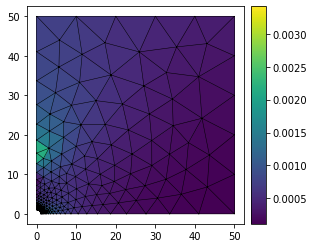

In [8]:
# we can test the system to see if there's any displacement in equilibrium
f_test = f + Matrix.assemble_tractions_over_line(mesh, tunnel, -stress_field)
solve = np.setdiff1d(np.arange(2*mesh.nn), dof_fixed)

u_solved = linalg.inv(K[solve][:, solve]) @ f_test[solve]
u = np.zeros(2*mesh.nn)
u[solve] = u_solved

print(f'Maximum displacement should be quite small: {np.abs(u_solved).max():.2e} m')
mesh.plot(np.linalg.norm(u.reshape(2, -1, order='F'), axis=0), shading='flat')

In [9]:
# we can solve for the undrained solution, defining the single large matrix
dt = 0
AA = S + dt*C

ntot_E = mesh.nn*2
ntot_P = mesh.nn
ntot = ntot_E + ntot_P

T = lil_matrix((ntot, ntot))
T[:ntot_E, :ntot_E] = K
T[ntot_E:, :ntot_E] = -Ce.T
T[:ntot_E, ntot_E:] = -Ce
T[ntot_E:, ntot_E:] = -AA

# we can now build the parts of the equations that we want to solve
displacement_free = np.setdiff1d(np.arange(ntot_E), dof_fixed)
eq_free = np.hstack([displacement_free, pore_pressure_free + ntot_E])
eq_fixed = np.setdiff1d(np.arange(ntot), eq_free)

# we need to set the force vector to the initial conditions, accounting to pore pressure
ftot = np.zeros(ntot)
ftot[:ntot_E] = f - Ce @ h
ftot[ntot_E:] = -AA @ h

# we solve the system
sol_undrained = lil_matrix((ntot, 1))
sol_undrained[eq_free] = linalg.inv(T[eq_free][:, eq_free]) @ ftot[eq_free]

# we can separate the solution in both displacement and pore pressure
displacement_undrained = sol_undrained[:ntot_E].toarray().reshape(2, -1, order='F')
pore_pressure_undrained = sol_undrained[ntot_E:].toarray()

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [20]:
#flux, M = Matrix.project_flux(mesh, kappa, pore_pressure_undrained, return_M=True)
#du = Matrix.project_stress(mesh, E, nu, sol_undrained[:ntot_E], M=M)

fig, ax, cb = mesh.plot(np.linalg.norm(displacement_undrained, axis=0), c='none')
ax.triplot(*(mesh.nodes.T + 100 * displacement_undrained), mesh.connectivity[:, :3], c='red', zorder=10, lw=1)
ax.set_xlim(-0.5, 3)
ax.set_ylim(-0.5, 3)
ax.set_title('vertical disp. (100x exaggeration)')

Text(0.5, 1.0, 'vertical disp. (100x exaggeration)')

In [11]:
# we want to compute the time varying solution on log-spaced time intervals
t = np.logspace(-1, 5, 100)
dt = np.diff(t)

solutions = np.zeros((len(t), ntot))
solutions[0] = sol_undrained.toarray()[:, 0]

T = T.tocsr()
# this loop is pretty long, can this be improved? look into sparses matrices operations
# might also be better to just swap for np arrays?
for i, dt_i in enumerate(dt):

    print(f'\riteration {i + 1} out of {len(dt)}', end='')

    # we adjust the total matrix with a varying dt
    T[ntot_E:, ntot_E:] = -(S + dt_i * C)
    # the change in flux is adjusted
    flux = dt_i * C[pore_pressure_free].dot(solutions[i, ntot_E:])
    ftot[pore_pressure_free + ntot_E] = flux


    # we can solve the system
    update = linalg.spsolve(T[eq_free][:, eq_free], ftot[eq_free])
    solutions[i + 1, eq_free] = solutions[i, eq_free] + update

# we can separate the displacements from the pore pressure to look at it
displacement_field = solutions[:, :ntot_E].reshape(len(t), 2, -1, order='F')
pore_pressure_field = solutions[:, ntot_E:]


iteration 99 out of 99

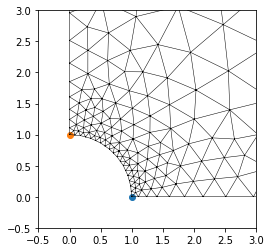

In [21]:
%matplotlib inline

# by extracting the values at a node, we can look at the temporal evolution of the closing of the tunnel
top = np.argmin(np.linalg.norm(mesh.nodes - np.array([0, r]), axis=1))
bottom = np.argwhere((mesh.nodes[:, 1] == 0) & (mesh.nodes[:, 0] == r))[:, 0]

mesh.plot()
plt.xlim(-0.5, 3)
plt.ylim(-0.5, 3)
plt.scatter(*mesh.nodes[bottom].T)
plt.scatter(*mesh.nodes[top].T)


(0.1, 100000.0)

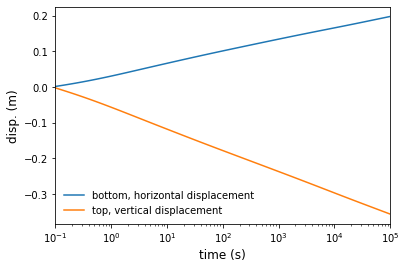

In [24]:
plt.plot(t, displacement_field[:, 0, bottom], label='bottom, horizontal displacement')
plt.plot(t, displacement_field[:, 1, top], label='top, vertical displacement')
plt.legend(frameon=False)
plt.xlabel('time (s)')
plt.ylabel('disp. (m)')
plt.xscale('log')
plt.xlim(t[0], t[-1])

No handles with labels found to put in legend.


(0.1, 100000.0)

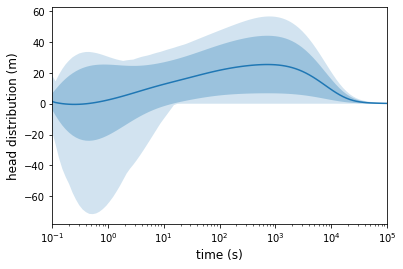

In [25]:
mean = pore_pressure_field.mean(axis=-1)
std = pore_pressure_field.std(axis=-1)
max = pore_pressure_field.max(axis=-1)
min = pore_pressure_field.min(axis=-1)


plt.plot(t, mean)
plt.fill_between(t, mean - std, mean + std, alpha=0.3)
plt.fill_between(t, min, max, alpha=0.2, fc='tab:blue')

plt.legend(frameon=False)
plt.xlabel('time (s)')
plt.ylabel('head distribution (m)')
plt.xscale('log')
plt.xlim(t[0], t[-1])

In [34]:
%matplotlib qt
# we can animate it

import types
from matplotlib.animation import ArtistAnimation, FFMpegWriter, FuncAnimation

vmax = np.abs(pore_pressure_field).max()

fig = plt.figure()
ax = fig.add_subplot()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], pore_pressure_field[0], lw=1, shading='gouraud',
                  vmin=-vmax, vmax=vmax, cmap='RdBu')
time = ax.set_title('t=0')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
plt.colorbar(im)
ax.set_aspect(1)
mesh.plot(ax=ax)

def update(i):
    time.set_text(f't={t[i]:.2f}')
    im.set_array(pore_pressure_field[i])
    return im, time

ani = FuncAnimation(fig, update, frames=len(t), interval=100)


In [16]:
%matplotlib qt
# we can animate it

import types
from matplotlib.animation import ArtistAnimation, FFMpegWriter, FuncAnimation

disp = np.linalg.norm(displacement_field, axis=1)

print(disp.shape)

fig = plt.figure()
ax = fig.add_subplot()
im = ax.tripcolor(*mesh.nodes.T, mesh.connectivity[:, :3], disp[0], lw=1, shading='gouraud')
time = ax.set_title('t=0')

def update(i):
    time.set_text(f't={t[i]:.2f}')
    im.set_array(disp[i])
    return im, time

ani = FuncAnimation(fig, update, frames=len(t), interval=100)


(100, 1115)


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(
